# Лабораторная работа №4
## Линейные модели, SVM и деревья решений.
## Выполнил Плешаков Владислав, РТ5-61Б
### Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие модели:
    * одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации);
    * SVM;
    * дерево решений.
5. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
6. Постройте график, показывающий важность признаков в дереве решений.
7. изуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

Датасет взят из прошлой лабораторной работы

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
import graphviz

In [2]:
data = pd.read_csv('data/out.csv', sep=',')

Разделение выборки на обучающую и тестовую

In [3]:
data_X = data.drop(columns=['Transported'])
data_y = data['Transported']

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, random_state=22)

### Логистическая регрессия

In [4]:
# Определяем параметры по которым будем производить решетчатый поиск
penalty_types = ['l1', 'l2']
c_param = [0.01 * (10**x) for x in range(5)]
params_for_logit_regr = {
    'penalty': penalty_types,
    'C': c_param,
    'solver': ['liblinear']
}

In [5]:
%%time

grid_search_logit = GridSearchCV(LogisticRegression(), params_for_logit_regr, scoring='f1_weighted', cv=5)
grid_search_logit.fit(train_X, train_y)

CPU times: total: 453 ms
Wall time: 463 ms


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1_weighted')

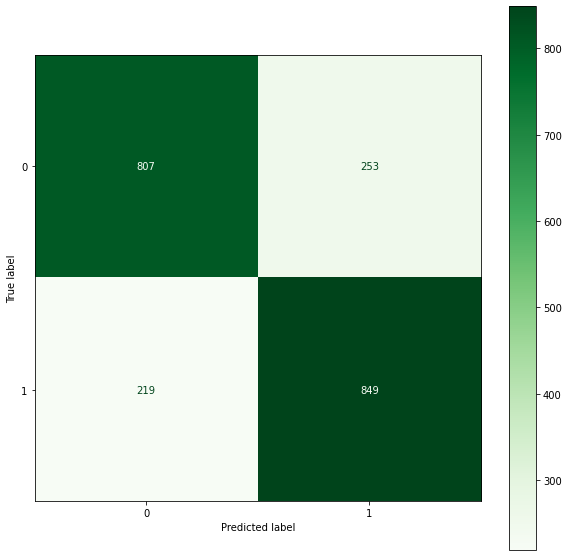

In [6]:
logit_regr = grid_search_logit.best_estimator_
logit_regr.fit(train_X, train_y)
logit_pred = logit_regr.predict(test_X)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(test_y, logit_pred, ax=ax, cmap='Greens')

In [7]:
accuracy_score(test_y, logit_pred)

0.7781954887218046

### Машина опорных векторов

In [8]:
params_for_rbf = {
    'C': c_param,
}

In [9]:
%%time

grid_search_svc = GridSearchCV(SVC(), params_for_rbf, scoring='f1_weighted', cv=5, n_jobs=4)
grid_search_svc.fit(train_X, train_y)

grid_search_svc.best_score_, grid_search_svc.best_params_

CPU times: total: 1.22 s
Wall time: 10.7 s


(0.7869129457125784, {'C': 10.0})

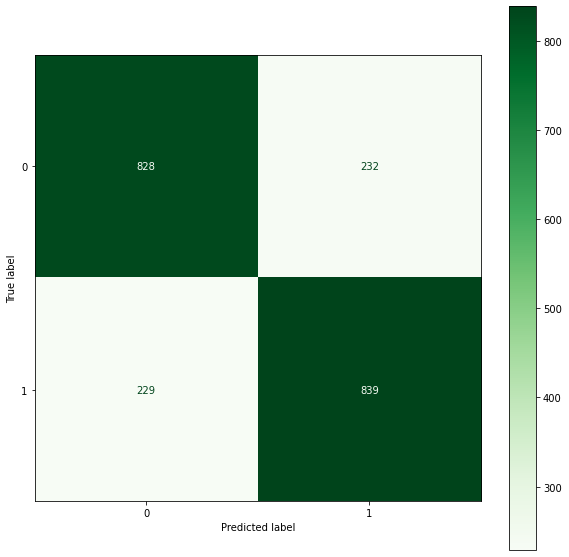

In [10]:
svc = grid_search_svc.best_estimator_
svc.fit(train_X, train_y)
svc_pred = svc.predict(test_X)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(test_y, svc_pred, ax=ax, cmap='Greens')

In [11]:
accuracy_score(test_y, svc_pred)

0.7833646616541353

### Решающее дерево

In [12]:
tree_params_search = {
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'min_samples_leaf': [0.04, 0.06, 0.08, 0.1, 0.2, 0.5, 1],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1]
}

In [13]:
%%time

grid_search_tree = GridSearchCV(DecisionTreeClassifier(), tree_params_search, scoring='accuracy', cv=5, n_jobs=4)
grid_search_tree.fit(train_X, train_y)
grid_search_tree.best_params_, grid_search_tree.best_score_

CPU times: total: 312 ms
Wall time: 1.76 s


({'max_depth': 8, 'max_features': 0.8, 'min_samples_leaf': 1},
 0.7762773005894006)

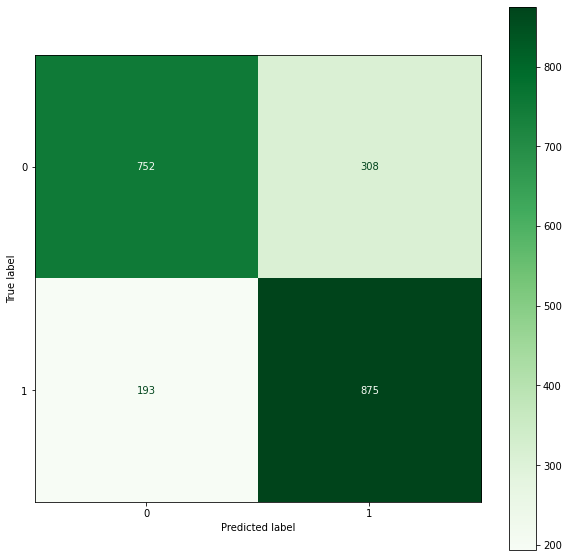

In [14]:
tree = grid_search_tree.best_estimator_
tree.fit(train_X, train_y)
tree_pred = tree.predict(test_X)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(test_y, tree_pred, ax=ax, cmap='Greens')

In [15]:
accuracy_score(test_y, tree_pred)

0.7645676691729323

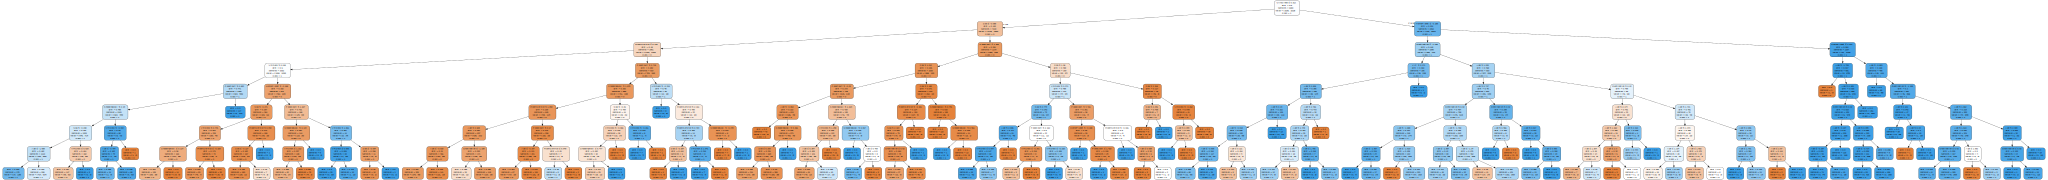

In [16]:
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None,
                           feature_names=list(data_X.columns),
                           class_names=['0', '1'],
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

Посмотрим на важность признаков в дереве решений

In [17]:
list(zip(data_X.columns.values, tree.feature_importances_))

[('Age', 0.05288727014633702),
 ('RoomService', 0.10079373475060478),
 ('FoodCourt', 0.07367862563060433),
 ('ShoppingMall', 0.033063794509189476),
 ('Spa', 0.09829388824967446),
 ('VRDeck', 0.12587608563020236),
 ('HomePlanet', 0.0699634253556213),
 ('CryoSleep', 0.4373127267803574),
 ('VIP', 6.836539868730944e-05),
 ('Destination', 0.008062083548721578)]